In [1]:
# initial creation
import pandas as pd
import tqdm
import py2neo

# pandas to read_csv , header = True
characters = pd.read_csv("C:/Users/sacha/Downloads/characters.csv")
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

graph.delete_all()

# CONSTRAINT if condition (here n.id_ is unique) not respected => error
# If constraint already exists pass (IF NOT EXISTS probably works too)
try:
    graph.run("CREATE CONSTRAINT ON (n:Superhero) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

# Init the list that will contains dicts for each node
transaction_list = []

# iterrows = line by line iterators of the df row[0] = id row[1] = the variables in columns
for row in tqdm.tqdm(characters.iterrows()):
    id_ = row[1]["characterID"]
    name = row[1]["name"]
    transaction_list.append({"id_":id_,"name":name})
    # Commit when list = 1000, vary it depending of the case
    if len(transaction_list) == 1000:
        # UNWIND = split the list given to it (here $json because json=transaction_list)
        # For each dict do the following query CREATE (n:Superhero) SET n = data
        transaction = "UNWIND $json as data CREATE (n:Superhero) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

# Some observation left (e.g 7700 node, will commit every 100. so 700 left)
graph.run(transaction, json=transaction_list)

pass

1170it [00:01, 894.96it/s]


In [2]:
import pandas as pd
import py2neo

stats = pd.read_csv("C:/Users/sacha/Downloads/characters_stats.csv")
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")


# OPTIONAL MATCH =>  search for the pattern described in it, while using nulls for missing parts of the pattern.
transaction = """UNWIND $json as data
OPTIONAL MATCH (a:Superhero {name:data.Name})
SET a += {Alignement:data.Alignement,Intelligence:data.Intelligence,Strength:data.Strength,Speed:data.Speed,Durability:data.Durability,
         Power:data.Power,Combat:data.Combat,Total:data.Total} 
"""

transaction_list = []

iteration = 0
for row in tqdm.tqdm(stats.iterrows()):
    transaction_list.append(dict(row[1]))
    iteration += 1
    if iteration % 1000 == 0:
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

pass

611it [00:00, 4027.29it/s]


In [3]:
# edges
import pandas as pd
import tqdm
import py2neo
import itertools

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

characters2comics = pd.read_csv("C:/Users/sacha/Downloads/charactersToComics.csv")
characters2comics = characters2comics.drop_duplicates()
transaction_list = []

# MERGE = if pattern does not exists ON CREATE
# If pattern exists do ON MATCH



transaction = """UNWIND $json as data
MATCH (a:Superhero),(b:Superhero)
WHERE a.id_ = data.id_1 AND b.id_ = data.id_2
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for comic in tqdm.tqdm(characters2comics.groupby(["comicID"])):
    related_ids = comic[1]["characterID"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"id_1":sh1,"id_2":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

100%|██████████| 22250/22250 [00:33<00:00, 673.88it/s] 


In [4]:
# Let's see if everything works well
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (a:Superhero{name:'Pepper Potts'})-[r:RELATION]-(b:Superhero{name:'Iron Man'}) RETURN r,a,b"""
data = graph.run(query).to_data_frame()
print(data["r"],data["a"],data["b"])

0    {'n_collab': 68}
Name: r, dtype: object 0    {'name': 'Pepper Potts', 'id_': 1009494}
Name: a, dtype: object 0    {'Speed': 58, 'Intelligence': 100, 'id_': 1009...
Name: b, dtype: object


                              ### Exercises
                              CRUD operations:

1) You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ?
    Are they related to each other ?

In [6]:
query = """MATCH (a:Superhero)
WHERE exists(a.Speed)
RETURN a
ORDER BY a.Speed DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["a"])

[Node('Superhero', Combat=56, Durability=84, Intelligence=75, Power=100, Speed=100, Strength=67, Total=482, id_=1009184, name='Black Bolt'),
 Node('Superhero', Combat=85, Durability=110, Intelligence=88, Power=100, Speed=100, Strength=85, Total=568, id_=1010764, name='Stardust'),
 Node('Superhero', Combat=56, Durability=60, Intelligence=63, Power=57, Speed=100, Strength=28, Total=364, id_=1009524, name='Quicksilver'),
 Node('Superhero', Combat=25, Durability=100, Intelligence=38, Power=100, Speed=100, Strength=60, Total=423, id_=1009477, name='Nova'),
 Node('Superhero', Combat=85, Durability=100, Intelligence=69, Power=100, Speed=92, Strength=100, Total=546, id_=1009664, name='Thor'),
 Node('Superhero', Combat=32, Durability=101, Intelligence=63, Power=100, Speed=84, Strength=100, Total=480, id_=1009592, name='Silver Surfer'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=83, Strength=100, Total=553, id_=1009312, name='Galactus'),
 Node('Superhero', C

2) How many have collaborated atleast more than 10 times with another superhero?

In [11]:
query = """
MATCH (a:Superhero)-[r:RELATION]-(b:Superhero)
WHERE r.n_collab > 10
RETURN COUNT(DISTINCT a) AS Superherocolab
LIMIT 10
"""

data = graph.run(query).to_data_frame()
superheroes_with_collab = list(data["Superherocolab"])
print("Number of superheroes with collaborations more than 10 times:", superheroes_with_collab[0])


Number of superheroes with collaborations more than 10 times: 528


3) Did the weakest of the MCU collaborated with the strongest ?

In [19]:
query = """
MATCH (a:Superhero), (b:Superhero)
WITH MIN(a.Strength) AS minStrength, MAX(b.Strength) AS maxStrength
MATCH (a:Superhero {Strength: minStrength}), (b:Superhero {Strength: maxStrength})
OPTIONAL MATCH (a)-[r:RELATION]-(b)
WITH a.name AS Weakest, b.name AS Strongest, COUNT(r) AS CollabCount
WHERE CollabCount = 1
RETURN Weakest, Strongest, CollabCount
"""

data = graph.run(query).to_data_frame()
print(data)


             Weakest   Strongest  CollabCount
0   Lady Deathstrike        Hulk            1
1   Lady Deathstrike        Thor            1
2   Lady Deathstrike  Apocalypse            1
3          Omega Red  Apocalypse            1
4          Omega Red  Juggernaut            1
..               ...         ...          ...
91           Stacy X        Thor            1
92           Stacy X  Wonder Man            1
93           Stacy X    Hercules            1
94           Stacy X  Juggernaut            1
95              Beak  Juggernaut            1

[96 rows x 3 columns]


4) Give a stats that interests you ! --> the 10 most intelligent superheroes

In [20]:
query = """MATCH (a:Superhero)
WHERE exists(a.Intelligence)
RETURN a
ORDER BY a.Intelligence DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["a"])



[Node('Superhero', Combat=70, Durability=95, Intelligence=100, Power=76, Speed=54, Strength=72, Total=467, id_=1009697, name='Vision'),
 Node('Superhero', Combat=70, Durability=70, Intelligence=100, Power=71, Speed=58, Strength=48, Total=417, id_=1009384, name='Kang'),
 Node('Superhero', Combat=32, Durability=14, Intelligence=100, Power=90, Speed=12, Strength=8, Total=256, id_=1009504, name='Professor X'),
 Node('Superhero', Combat=84, Durability=100, Intelligence=100, Power=93, Speed=20, Strength=32, Total=429, id_=1009281, name='Doctor Doom'),
 Node('Superhero', Combat=42, Durability=14, Intelligence=100, Power=58, Speed=12, Strength=10, Total=236, id_=1009398, name='Leader'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=83, Strength=100, Total=553, id_=1009312, name='Galactus'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=67, Strength=80, Total=517, id_=1009327, name='Jean Grey'),
 Node('Superhero', Combat=60, 

5) Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, 
    Group of 3 that collab (undirected relation).

In [ ]:
with neo4j Create a new db called "master". Create a graph from the M1 class with name and 
random age between 20 and 30, Group of 3 that collab (undirected relation).
il faut que je fasse 15 noms et prénoms qui sont partie du master M1 à chacun d'entre eux un âge aléatoire entre 20 et 30 et group
of 3 that collab (undirected relation meaning symetrical relation)



In [5]:
import tqdm
import py2neo
import numpy as np
import random
from py2neo import Node,Relationship
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")

# Noms des personnes
person_names = [
    "Sacha", "Oumou", "Georgiana", "Valentin", "Benie", 
    "Huyiue", "Romain", "Adrien", "Werner", "Paul", 
    "Lath", "Carl", "Celestin", "Nathan", "Julien"
]

# Fonction pour créer un nœud de la classe M1 avec un nom spécifique et un âge aléatoire
def create_m1_node(name):
    age = random.randint(20, 30)
    return Node("M1", name=name, age=age)

# Création des nœuds de la classe M1 avec les noms spécifiques
m1_nodes = [create_m1_node(name) for name in person_names]

# Création des relations de collaboration entre les membres du groupe de 3 collaborateurs
collaborators = [Node("Collaborator", name=f"Collaborator{i}") for i in range(1, 4)]
for i in range(len(collaborators)):
    for j in range(i + 1, len(collaborators)):
        rel = Relationship(collaborators[i], "COLLABORATE_WITH", collaborators[j])
        graph.create(rel)

# Ajout des nœuds M1 et de leurs relations avec les collaborateurs au graphe
for node in m1_nodes:
    graph.create(node)
    for collaborator in collaborators:
        rel = Relationship(node, "COLLABORATE_WITH", collaborator)
        graph.create(rel)

In [10]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")

graph.delete_all()

In [11]:
import py2neo
import numpy as np
import random
from py2neo import Node, Relationship

# Connexion à la base de données Neo4j
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")
graph.delete_all()

# Noms des personnes dans la classe M1
person_names = [
    "Sacha", "Oumou", "Georgiana", "Valentin", "Benie", 
    "Huyiue", "Romain", "Adrien", "Werner", "Paul", 
    "Lath", "Carl", "Celestin", "Nathan", "Julien"
]

# Création des nœuds pour les personnes de la classe M1 avec leurs noms et des âges aléatoires
m1_nodes = []
for name in person_names:
    age = random.randint(20, 30)
    m1_node = Node("M1", name=name, age=age)
    graph.create(m1_node)
    m1_nodes.append(m1_node)

# Création des collaborations pour chaque personne avec trois autres personnes
for i, node in enumerate(m1_nodes):
    # Choix de trois autres personnes aléatoires pour la collaboration
    collaborators = random.sample(m1_nodes[:i] + m1_nodes[i+1:], 3)
    for collaborator in collaborators:
        # Création de la relation de collaboration entre les deux nœuds
        rel = Relationship(node, "COLLABORATE_WITH", collaborator)
        graph.create(rel)


6) Get the age for people YOU collaborate with.

In [17]:
# Cypher query to get the ages of people Sacha collaborates with
query = """
MATCH (sacha:M1 {name: 'Sacha'})-[:COLLABORATE_WITH]->(collaborator)
RETURN collaborator.name AS collaborator_name, collaborator.age AS collaborator_age
"""

result = graph.run(query)

# Print the ages of collaborators
for record in result:
    collaborator_name = record["collaborator_name"]
    collaborator_age = record["collaborator_age"]
    print(f"{collaborator_name}: {collaborator_age} years old")
    #print(record["collaborator.age"])

Nathan: 30 years old
Paul: 29 years old
Valentin: 24 years old


7) Get nodes with age > 25.

In [21]:
query="""
MATCH (n:M1)
WHERE n.age > 25
RETURN n.name AS name, n.age AS age
"""
result = graph. run(query)
# Retrieve and print the nodes with age > 25
for record in result:
    name = record["name"]
    age = record["age"]
    print(f"{name}: {age} years old")

Oumou: 28 years old
Benie: 27 years old
Adrien: 29 years old
Paul: 29 years old
Lath: 29 years old
Celestin: 30 years old
Nathan: 30 years old
Julien: 29 years old


##                              Real world problem

8) Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

In [2]:
import requests
import feedparser
import tqdm
import time
import pymongo
import csv
from pymongo import MongoClient

client = pymongo.MongoClient('localhost',27017)
mydb = client["tutorial"]
collection = mydb["arxiv_api"]
arxivapi = collection.find()

with open('arxivapi.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['id', 'title', 'authors', 'published', 'published_parsed']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for document in arxivapi:
        writer.writerow({'id': document['id'], 'title': document['title'], 'authors': document['authors'], 'published': document['published'], 'published_parsed': document['published_parsed']})
        

In [8]:
import py2neo
from py2neo import ogm
import numpy as np
from py2neo import Graph, Node, Relationship
import csv

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="arxiv")
csv_file = "C:/Users/sacha/Downloads/arxivapi.csv"

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Extraire les auteurs de la colonne "authors"
        authors = row['authors']
        author_names = [author.strip().split(':')[1].strip() for author in authors.split(',') if 'name' in author]
        
        # Créer un nœud pour chaque auteur
        for author_name in author_names:
            author_node = Node("Author", name=author_name)
            graph.merge(author_node, "Author", "name")  # Spécifiez l'étiquette principale et la clé primaire




KeyboardInterrupt: 

In [12]:
csv_file = "C:/Users/sacha/Downloads/arxivapi.csv"

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:

        published_year = row['published_parsed'][0]
        
        # Vérifier si l'article a été publié après 2021
        if published_year > "2021":
            # Extraire les auteurs de la colonne "authors"
            authors = row['authors']
            author_names = [author.strip().split(':')[1].strip() for author in authors.split(',') if 'name' in author]
            
            # Créer un nœud pour chaque auteur s'il n'existe pas déjà
            for author_name in author_names:
                author_node = Node("Author", name=author_name)
                graph.merge(author_node, "Author", "name")
            
            # Créer des liens de collaboration entre tous les auteurs de l'article
            for i in range(len(author_names)):
                for j in range(i + 1, len(author_names)):
                    author1_node = graph.nodes.match("Author", name=author_names[i]).first()
                    author2_node = graph.nodes.match("Author", name=author_names[j]).first()
                    if author1_node and author2_node:
                        collab_rel = Relationship(author1_node, "COLLABORATE", author2_node)
                        graph.merge(collab_rel)

KeyboardInterrupt: 

9) Get the density of degrees of the collaboration network

C:\Users\sacha\AppData\Local\Temp\ipykernel_31596\4167221071.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(collaborations, hist=False)


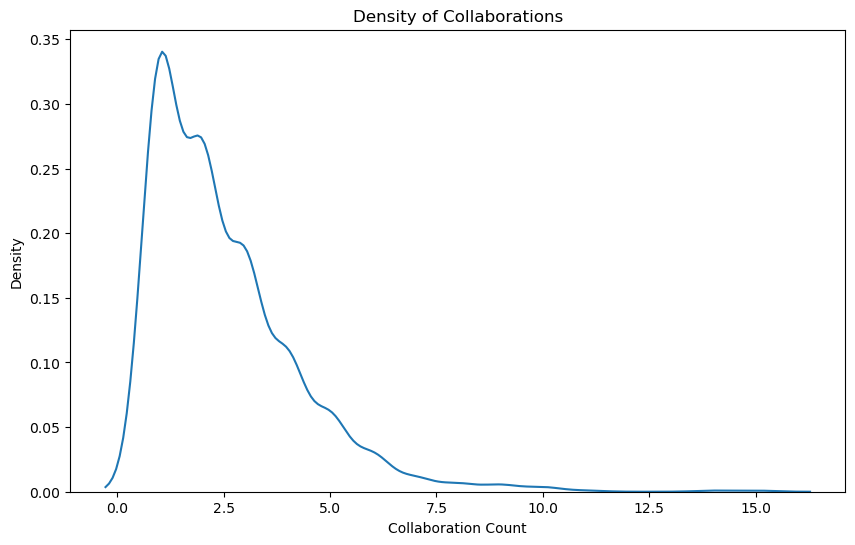

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="arxiv")
query="""
MATCH (a:Author)-[:COLLABORATE]->(b:Author)
RETURN a.name AS author, COUNT(b) AS collaboration_count
"""

# Exécution de la requête et récupération des résultats
result = graph.run(query)

# Extraction des collaborations par auteur
collaborations = [record["collaboration_count"] for record in result]

# Tracé de la densité des collaborations
plt.figure(figsize=(10, 6))
ax = sns.distplot(collaborations, hist=False)
ax.set_title("Density of Collaborations")
ax.set_xlabel("Collaboration Count")
ax.set_ylabel("Density")
plt.show()

10) Do a for loop for i in range(500) for each i remove nodes with a degree less than i.

In [ ]:
for i in range(500):
    # Construction de la requête Cypher pour supprimer les nœuds avec un degré inférieur à i
    query = f"""
    MATCH (a:Author)
    WHERE size((a)-[:COLLABORATE]-()) < {i}
    DETACH DELETE a
    """
    graph.run(query)

   ##                   Real World application 3
You will work again on pubmed_last_100k.json. The goal in this homework is to insert collaboration data in Neo4j and then study it using cypher queries. The following questions are meant to guide you through the process.

    1)Each paper has a list of author and affiliations. The first step is to create a node per author with a list 
    of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge 
    between two authors if they are on the same paper. You can use any kind of operation to clean the data before 
    inserting,you decide which preprocessing step is the most convenient.

In [43]:
import json

# Charger le fichier JSON
with open("C:/Users/sacha/Downloads/pubmed_cleaned (1)/pubmed_cleaned.json", 'r') as json_file:
    data = json.load(json_file)

# Afficher les premières lignes du JSON
print(data[:5])
# Spécifier le chemin d'accès au fichier CSV de sortie
csv_file = 'pubmed_cleaned.csv'

# Extraire les noms de colonnes en tant qu'en-têtes
headers = list(data[0].keys())

# Écrire les données JSON dans le fichier CSV
with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()
    writer.writerows(data)


[{'_id': {'$oid': '60c715b4c4b7559e04fd9d24'}, 'pmid': 30006494, 'title': 'Proton pump inhibitors and gastric cancer: association is not causation.', 'ISSN': '1468-3288', 'abstract': None, 'meshwords': 'Anti-Ulcer Agents \nHelicobacter pylori \nHumans \nProton Pump Inhibitors \nStomach Neoplasms ', 'meshsubwords': '', 'authors': "name ml Moayyedi P, affil str Division of Gastroenterology and Farncombe Family Digestive Health Research Institute, McMaster University, Hamilton, Ontario, Canada.\nname ml Veldhuyzen van Zanten SJO, affil str Division of Gastroenterology, University of Alberta, Edmonton, Alberta, Canada.\nname ml Hookey L, affil str Division of Gastroenterology, Queen\\'s University, Kingston, Ontario, Canada.\nname ml Armstrong D, affil str Division of Gastroenterology and Farncombe Family Digestive Health Research Institute, McMaster University, Hamilton, Ontario, Canada.\nname ml Jones N, affil str Division of Gastroenterology, Hepatology, and Nutrition, The Hospital for 

KeyboardInterrupt: 

In [6]:
import py2neo
import json
import re
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmedclean")
# Charger le fichier JSON
with open("C:/Users/sacha/Downloads/pubmed_cleaned (1)/pubmed_cleaned.json", 'r') as json_file:
    data = json.load(json_file)

for entry in data:
    # Extraire le titre de l'article
    title = entry['title']
    
    # Extraire les noms et les affiliations des auteurs de l'article actuel
    authors_affiliations = re.findall(r'name ml (.*?), affil str (.*?)\.', entry['authors'])
    
    # Créer un nœud pour chaque auteur avec le titre et l'affiliation comme attributs
    for author, affiliation in authors_affiliations:
        author_node = Node("Author", name=author, title=title, affiliation=affiliation)
        graph.create(author_node)
    
    # Créer des arêtes entre les auteurs qui ont le même titre
    for i in range(len(authors_affiliations)):
        for j in range(i + 1, len(authors_affiliations)):
            author1 = authors_affiliations[i][0]  # Nom du premier auteur
            author2 = authors_affiliations[j][0]  # Nom du deuxième auteur
            graph.run(
                "MATCH (a:Author {name: $author1}), (b:Author {name: $author2}) "
                "CREATE (a)-[:SAME_TITLE]->(b)",
                author1=author1, author2=author2
            )

KeyboardInterrupt: 

2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

C:\Users\sacha\AppData\Local\Temp\ipykernel_7492\970564384.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data["degree"],hist=False)


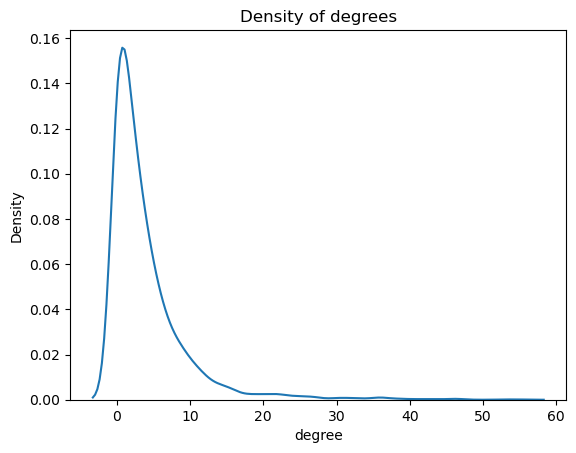

In [7]:
# density of degrees
import seaborn as sns
import py2neo
import pandas as pd
# The WITH clause allows query parts to be chained together, 
# piping the results from one to be used as starting points or criteria in the next.
# size(()-[:RELATION]->(p)) = number of relation that goes into node p  
query = """
MATCH (n)
RETURN size((n)-->()) AS degree
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")

                   Real World application 4
    change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph
    then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. 
    Answer the following questions with cypher queries.


1) How many actors played in more than 2 movie ? Get their names and year they were born.

In [23]:
import tqdm
import py2neo
import numpy as np
import random
from py2neo import Node,Relationship

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="movie")



# Cypher query to find actors who played in more than 2 movies and get their names and birth years
query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)
WITH actor, COUNT(movie) AS movie_count
WHERE movie_count > 2
RETURN actor.name AS actor_name, actor.born AS birth_year
"""

result = graph.run(query)

# Print the names and birth years of actors who played in more than 2 movies
for record in result:
    print(record["actor_name"], record["birth_year"])


Keanu Reeves 1964
Carrie-Anne Moss 1967
Laurence Fishburne 1961
Hugo Weaving 1960
Tom Cruise 1962
Jack Nicholson 1937
Kevin Bacon 1958
Cuba Gooding Jr. 1968
Meg Ryan 1961
Helen Hunt 1963
Robin Williams 1951
Tom Hanks 1956
Gene Hackman 1930
Ben Miles 1967
Bill Paxton 1955


    2) In how many movies did Tom hanks play ?

In [3]:
import tqdm
import py2neo
import numpy as np
import random
from py2neo import Node,Relationship

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="movie")



# Define the Cypher query
cypher_query = """
MATCH (tom:Person {name: "Tom Hanks"})-[:ACTED_IN]->(movie)
RETURN COUNT(movie) AS NumberOfMovies
"""

# Execute the Cypher query
result = graph.run(cypher_query)

# Extract the result
number_of_movies = result.evaluate()

# Print the result
print("Number of movies:", number_of_movies)

Number of movies: 12


    3) In average in how many movies do actors play in ?

In [4]:
query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)
WITH actor, COUNT(movie) AS movieCount
RETURN AVG(movieCount) AS AverageMoviesPerActor
"""

# Execute the Cypher query
result = graph.run(query)

# Extract the result
average_movies_per_actor = result.evaluate()

# Print the result
print("Average number of movies per actor:", average_movies_per_actor)

Average number of movies per actor: 1.686274509803922


    4) In average how many actors are there in a movie ?

In [7]:
cypher_query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)
WITH movie, COUNT(actor) AS actorCount
RETURN AVG(actorCount) AS AverageActorsPerMovie
"""

# Execute the Cypher query
result = graph.run(cypher_query)

# Extract the result
average_actors_per_movie = result.evaluate()

# Print the result
print("Average number of actors per movie:", average_actors_per_movie)

Average number of actors per movie: 4.526315789473685


    5) In average how many writers is needed to write a movie ?

In [6]:
# Define the Cypher query
cypher_query = """
MATCH (writer:Person)-[:WROTE]->(movie)
WITH movie, COUNT(writer) AS writerCount
RETURN AVG(writerCount) AS AverageWritersPerMovie
"""

# Execute the Cypher query
result = graph.run(cypher_query)

# Extract the result
average_writers_per_movie = result.evaluate()

# Print the result
print("Average number of writers per movie:", average_writers_per_movie)

Average number of writers per movie: 1.25


    7) Do an histogram of the year of release for the movies.

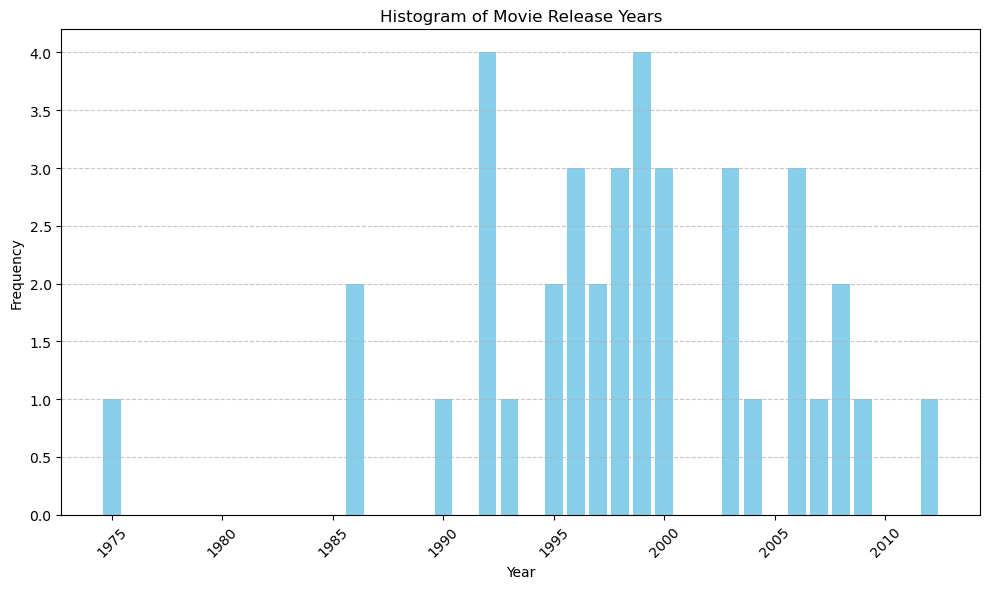

In [12]:
import matplotlib.pyplot as plt

# Define the Cypher query
cypher_query = """
MATCH (movie:Movie)
WHERE EXISTS(movie.released)
RETURN movie.released AS Year, COUNT(*) AS Frequency
ORDER BY Year
"""

# Execute the Cypher query
result = graph.run(cypher_query)

# Extract data for histogram
years = []
frequencies = []
for record in result:
    years.append(record["Year"])
    frequencies.append(record["Frequency"])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Release Years')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

    8) Who are the 10 actors with the most movie played in

In [13]:
cypher_query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)
RETURN actor.name AS ActorName, COUNT(movie) AS MovieCount
ORDER BY MovieCount DESC
LIMIT 10
"""

# Execute the Cypher query
result = graph.run(cypher_query)

# Print the top 10 actors based on the number of movies they have acted in
print("Top 10 Actors by Number of Movies:")
for record in result:
    actor_name = record["ActorName"]
    movie_count = record["MovieCount"]
    print(f"{actor_name}: {movie_count} movies")

Top 10 Actors by Number of Movies:
Tom Hanks: 12 movies
Keanu Reeves: 7 movies
Meg Ryan: 5 movies
Hugo Weaving: 5 movies
Jack Nicholson: 5 movies
Cuba Gooding Jr.: 4 movies
Laurence Fishburne: 3 movies
Carrie-Anne Moss: 3 movies
Tom Cruise: 3 movies
Kevin Bacon: 3 movies


    9) Delete every movie made by a director of your choosing

In [14]:
cypher_query = """
MATCH (director:Person {name: 'Harvey Weinstein'})-[:DIRECTED]->(movie:Movie)
DETACH DELETE movie
"""

# Execute the Cypher query
graph.run(cypher_query)

(No data)

    11) Sandbox exercise: think of a problematic and try to answer it.### Real World application 4

In [29]:
# Cypher query to find the top 10 collaborations
query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)<-[:DIRECTED]-(director:Person)
WITH actor, director, movie
MATCH (co_actor:Person)-[:ACTED_IN]->(movie)
WHERE co_actor <> actor
RETURN actor.name AS actor_name, co_actor.name AS co_actor_name, director.name AS director_name, movie.title AS movie_title, count(*) AS collaboration_count
ORDER BY collaboration_count DESC
LIMIT 10
"""

result = graph.run(query)

# Print the result
print("Top 10 Collaborations:")
for record in result:
    actor_name = record["actor_name"]
    co_actor_name = record["co_actor_name"]
    director_name = record["director_name"]
    movie_title = record["movie_title"]
    collaboration_count = record["collaboration_count"]
    print(f"{actor_name} collaborated with {co_actor_name} (Directed by {director_name}) in '{movie_title}' ({collaboration_count} collaborations)")

Top 10 Collaborations:
Christina Ricci collaborated with Emile Hirsch (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Ben Miles collaborated with Emile Hirsch (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Susan Sarandon collaborated with Emile Hirsch (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
John Goodman collaborated with Emile Hirsch (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Matthew Fox collaborated with Emile Hirsch (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Emile Hirsch collaborated with Rain (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Christina Ricci collaborated with Rain (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Ben Miles collaborated with Rain (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Susan Sarandon collaborated with Rain (Directed by Lilly Wachowski) in 'Speed Racer' (1 collaborations)
Rain collaborate

##       Real World application 5
You will work on a Twitch dataset found here. The goal is to learn more about the feat&fun on Twitch. 
First thing to do is create the network on Neo4j. Insert the node from Twitch/FR_target and then the edges
from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

In [35]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")
graph.delete_all()

In [36]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")
with open("C:/Users/sacha/Downloads/FR_target.csv", 'r') as file:
    for line in file:
        id, days, mature, views, partner, new_id = line.strip().split(',')  
        graph.run(
            "CREATE (:TwitchUser {id: $id, days: $days, mature: $mature, views: $views, partner:$partner, new_id:$new_id})",
            {"id": id, "days": days, "mature": mature, "views": views, "partner":partner, "new_id":new_id}
        )
        

In [37]:
with open("C:/Users/sacha/Downloads/FR_edges.csv", 'r') as file:
    for line in file:
        source_id, target_id = line.strip().split(',')  
        graph.run(
            "MATCH (source:TwitchUser {new_id: $source_id}) "
            "MATCH (target:TwitchUser {new_id: $target_id}) "
            "CREATE (source)-[:FOLLOWS]->(target)",
            {"source_id": source_id, "target_id": target_id}
        )

KeyboardInterrupt: 

1) Give the IDs of the top 10 streamers that have atleast one collaboration.

In [38]:
query = """
MATCH (streamer:TwitchUser)-[:FOLLOWS]->(:TwitchUser)
WITH streamer, count(*) AS collaborations
WHERE collaborations > 0
RETURN streamer.id AS streamer_id, collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

# Exécution de la requête Cypher
result = graph.run(query)

# Affichage des résultats
for record in result:
    print(record["streamer_id"])


94830708
84934926
27115917
48759454
71287551
73646532
71123283
84967471
28279435
170576709


In [14]:
from py2neo import Graph
import pandas as pd
from scipy.stats import pearsonr

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")

# Define Cypher queries to fe
query = """
MATCH (streamer:TwitchUser)-[:FOLLOWS]->(:TwitchUser)
WITH streamer, count(*) AS collaborations
WHERE collaborations > 0
RETURN streamer.id AS streamer_id, collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

# Exécution de la requête Cypher
result = graph.run(query)

# Affichage des résultats
for record in result:
    print(record["streamer_id"])


94830708
84934926
27115917
48759454
71287551
73646532
71123283
84967471
28279435
170576709


2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

C:\Users\sacha\AppData\Local\Temp\ipykernel_29544\1155981179.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data["degree"],hist=False)


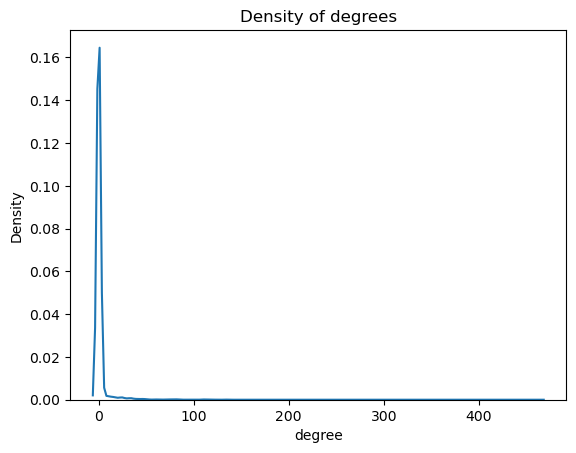

In [40]:
# density of degrees
import seaborn as sns
import py2neo
import pandas as pd

query = """
MATCH (n)
RETURN size((n)-->()) AS degree
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")

3) How many streamers has the tag "mature" ?

In [15]:
query = """
MATCH (streamer:TwitchUser)
WHERE streamer.mature = 'True'
RETURN COUNT(streamer) AS mature_streamers
"""

result = graph.run(query)
record = result.next()
mature_streamers = record["mature_streamers"]

print(mature_streamers)

2416


  4) Which country has seen the most international collaboration ?

In [16]:
query_true = """
MATCH (streamer:TwitchUser {mature: 'True'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_true
"""

result_true = graph.run(query_true)

record_true = result_true.next()

# Nombre total de collaborations des streamers avec mature=True
total_collaborations_true = record_true["total_collaborations_true"]

query_false = """
MATCH (streamer:TwitchUser {mature: 'False'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_false
"""


result_false = graph.run(query_false)


record_false = result_false.next()

# Nombre total de collaborations des streamers avec mature=False
total_collaborations_false = record_false["total_collaborations_false"]


print("Nombre total de collaborations des streamers avec mature=True avec les autres:", total_collaborations_true)
print("Nombre total de collaborations des streamers avec mature=False avec les autres:", total_collaborations_false)

Nombre total de collaborations des streamers avec mature=True avec les autres: 4331
Nombre total de collaborations des streamers avec mature=False avec les autres: 6311


5) Do partners collaborate more than non partners ?

In [17]:
query_true = """
MATCH (streamer:TwitchUser {partner: 'True'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_partners
"""

# Exécution de la requête Cypher
result_true = graph.run(query_true)

# Récupérer le premier enregistrement dans le curseur
record_true = result_true.next()

# Nombre total de collaborations des streamers avec partner=True
total_collaborations_partners = record_true["total_collaborations_partners"]

# Requête Cypher pour compter le nombre total de collaborations des streamers avec partner=False
query_false = """
MATCH (streamer:TwitchUser {partner: 'False'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_nonpartners
"""

# Exécution de la requête Cypher
result_false = graph.run(query_false)

# Récupérer le premier enregistrement dans le curseur
record_false = result_false.next()

# Nombre total de collaborations des streamers avec partner=False
total_collaborations_nonpartners = record_false["total_collaborations_nonpartners"]

# Affichage des résultats
print("Nombre total de collaborations des streamers avec partner=True avec les autres:", total_collaborations_partners)
print("Nombre total de collaborations des streamers avec partner=False avec les autres:", total_collaborations_nonpartners)

Nombre total de collaborations des streamers avec partner=True avec les autres: 1975
Nombre total de collaborations des streamers avec partner=False avec les autres: 8667


     Sandbox exercise: think of a problematic and try to answer it.

In [18]:
from py2neo import Graph

# Connect to Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")

# Query to identify influential users based on degree centrality
query = """
MATCH (u:TwitchUser)
RETURN u.id AS userId, size((u)-[:FOLLOWS]->()) AS followersCount
ORDER BY followersCount DESC
LIMIT 10
"""

# Execute the query
result = graph.run(query)

# Print the top 10 influential users
for record in result:
    print("User ID:", record["userId"], "Followers Count:", record["followersCount"])


User ID: 94830708 Followers Count: 462
User ID: 84934926 Followers Count: 289
User ID: 27115917 Followers Count: 265
User ID: 48759454 Followers Count: 232
User ID: 71287551 Followers Count: 214
User ID: 73646532 Followers Count: 147
User ID: 71123283 Followers Count: 135
User ID: 84967471 Followers Count: 133
User ID: 28279435 Followers Count: 121
User ID: 170576709 Followers Count: 119


    ## Real World application 6
    You will work on a stackoverflow dataset found here. First thing to do is create the network on Neo4j.
    You can find the characteristics of the nodes in stack_network_nodes.csv. Once the node are create you can create the edges     between them, you can find them in stack_network_links.csv. The weight of the edge is the column value. Answer the following     making use of cypher queries.

In [27]:
from py2neo import Graph

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="starkoverflow")

# Create nodes
with open("C:/Users/sacha/Downloads/stack_network_nodes.csv", 'r') as file:
    next(file)  # Skip the header row
    for line in file:
        name, group, nodesize = line.strip().split(',')
        query = """
        CREATE (:Node {name: $name, group: $group, nodesize: $nodesize})
        """
        graph.run(query, name=name, group=group, nodesize=float(nodesize))

# Create edges
with open("C:/Users/sacha/Downloads/stack_network_links.csv", 'r') as file:
    next(file)  # Skip the header row
    for line in file:
        source, target, value = line.strip().split(',')
        query = """
        MATCH (source:Node {name: $source})
        MATCH (target:Node {name: $target})
        MERGE (source)-[:LINK {weight: $value}]->(target)
        """
        graph.run(query, source=source, target=target, value=float(value))



total_nodes_query = """
MATCH (n:Node)
RETURN count(n) AS TotalNodes
"""
total_nodes_result = graph.run(total_nodes_query).to_table()[0][0]  # Extracting the count value
print("Total number of nodes:", total_nodes_result)

total_edges_query = """
MATCH ()-[r:LINK]->()
RETURN count(r) AS TotalEdges
"""
total_edges_result = graph.run(total_edges_query).to_table()[0][0]  # Extracting the count value
print("Total number of edges:", total_edges_result)


Total number of nodes: 345
Total number of edges: 4410


  1) What are the 10 most popular keywords ?

In [28]:
from py2neo import Graph

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="starkoverflow")

# Define the Cypher query
cypher_query = """
MATCH (n:Node)
RETURN n.name AS Keyword, sum(n.nodesize) AS Popularity
ORDER BY Popularity DESC
LIMIT 10
"""

# Execute the query
result = graph.run(cypher_query)

# Iterate over the result and print the top 10 keywords
print("Top 10 most popular keywords:")
for record in result:
    print(record["Keyword"], "-", record["Popularity"])


Top 10 most popular keywords:
javascript - 1947.48
java - 1831.9499999999998
python - 1316.01
php - 1083.66
css - 1023.51
c# - 963.39
html - 817.3499999999999
c++ - 804.33
android - 689.58
jquery - 624.87


  2) What are the top 10 Co-occurence ?

In [29]:
# Define the Cypher query
cypher_query = """
MATCH (k1:Node)-[:LINK]->(k2:Node)
WHERE k1.name < k2.name
RETURN k1.name AS Keyword1, k2.name AS Keyword2, count(*) AS CoOccurrence
ORDER BY CoOccurrence DESC
LIMIT 10
"""

# Execute the query
result = graph.run(cypher_query)

# Print the top 10 co-occurrences
print("Top 10 co-occurrences:")
for record in result:
    print(record["Keyword1"], "-", record["Keyword2"], ":", record["CoOccurrence"])

Top 10 co-occurrences:
html - jquery : 9
html - php : 9
html - mysql : 9
html - sass : 9
css - html : 9
css - html5 : 9
css - javascript : 9
css - jquery : 9
css - php : 9
html - javascript : 9


  3) How many keywords are in group 1 ?

In [30]:
cypher_query = """
MATCH (n:Node)
WHERE n.group = '1'
RETURN count(n) AS NumberOfKeywordsInGroup1
"""

# Execute the query
result = graph.run(cypher_query)

# Extract the result
number_of_keywords = result.evaluate()

# Print the result
print("Number of keywords in group 1:", number_of_keywords)

Number of keywords in group 1: 30


  4) Is the Co-occurence correlated to the "group" of the keyword ?

In [31]:
from py2neo import Graph

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="starkoverflow")

# Define the Cypher query to count co-occurrences within the same group
cypher_query_same_group = """
MATCH (k1:Node)-[:LINK]->(k2:Node)
WHERE k1.group = k2.group
RETURN count(*) AS CoOccurrenceWithinSameGroup
"""

# Define the Cypher query to count co-occurrences across different groups
cypher_query_diff_group = """
MATCH (k1:Node)-[:LINK]->(k2:Node)
WHERE k1.group <> k2.group
RETURN count(*) AS CoOccurrenceAcrossDifferentGroups
"""

# Execute the queries
result_same_group = graph.run(cypher_query_same_group).evaluate()
result_diff_group = graph.run(cypher_query_diff_group).evaluate()

# Print the results
print("Co-occurrence within the same group:", result_same_group)
print("Co-occurrence across different groups:", result_diff_group)


Co-occurrence within the same group: 3960
Co-occurrence across different groups: 450


    Sandbox exercise: think of a problematic and try to answer it.

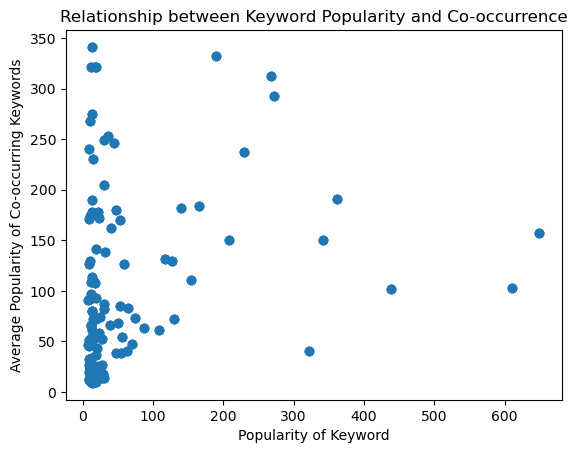

Correlation coefficient: 0.23155028380687043


In [32]:
from py2neo import Graph
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="starkoverflow")

# Define the Cypher query
cypher_query = """
MATCH (k1:Node)-[:LINK]->(k2:Node)
WITH k1, AVG(k2.nodesize) AS AvgPopularityCoOccur
RETURN k1.name AS Keyword, k1.nodesize AS Popularity, AvgPopularityCoOccur
"""

# Execute the query and store the result in a DataFrame
result = graph.run(cypher_query).to_data_frame()

# Calculate correlation coefficient
correlation_coefficient = result["Popularity"].corr(result["AvgPopularityCoOccur"])

# Visualize the relationship
plt.scatter(result["Popularity"], result["AvgPopularityCoOccur"])
plt.xlabel("Popularity of Keyword")
plt.ylabel("Average Popularity of Co-occurring Keywords")
plt.title("Relationship between Keyword Popularity and Co-occurrence")
plt.show()

# Print the correlation coefficient
print("Correlation coefficient:", correlation_coefficient)
